### Setup & Imports

In [1]:
# --- Setup ---
import pandas as pd
import numpy as np
import random
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error
)
from xgboost import XGBClassifier
import lightgbm as lgb

random_seed = 42
np.random.seed(random_seed)

### Load Data

In [2]:
train_origin = pd.read_csv("data/train.csv")
print("Original shape:", train_origin.shape)
train_origin.head()


Original shape: (37670293, 24)


,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


### EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37670293 entries, 0 to 37670292
Data columns (total 24 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   date_time                  object 
 1   site_name                  int64  
 2   posa_continent             int64  
 3   user_location_country      int64  
 4   user_location_region       int64  
 5   user_location_city         int64  
 6   orig_destination_distance  float64
 7   user_id                    int64  
 8   is_mobile                  int64  
 9   is_package                 int64  
 10  channel                    int64  
 11  srch_ci                    object 
 12  srch_co                    object 
 13  srch_adults_cnt            int64  
 14  srch_children_cnt          int64  
 15  srch_rm_cnt                int64  
 16  srch_destination_id        int64  
 17  srch_destination_type_id   int64  
 18  is_booking                 int64  
 19  cnt                        int64  
 20  

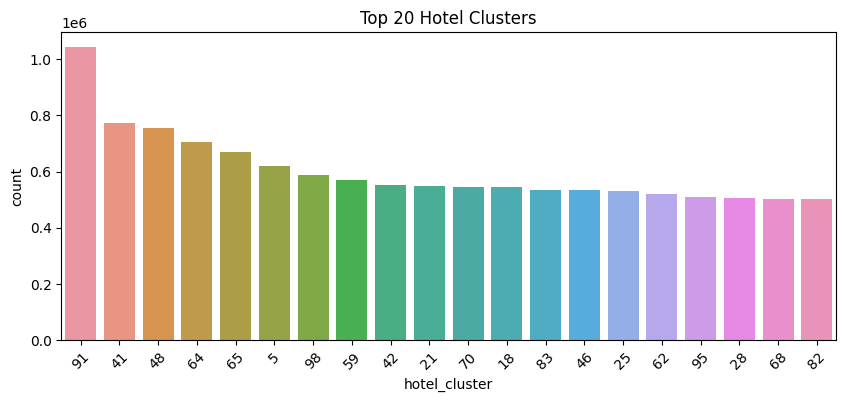

In [3]:
train_origin.info()
train_origin.describe(include='all')

# Check missing values
train_origin.isna().mean().sort_values(ascending=False).head(10)

# Quick look at top hotel clusters
plt.figure(figsize=(10,4))
sns.countplot(x='hotel_cluster', data=train_origin, order=train_origin['hotel_cluster'].value_counts().index[:20])
plt.title('Top 20 Hotel Clusters')
plt.xticks(rotation=45)
plt.show()


### Data Sampling

In [4]:
# Use a 1M-row sample for faster experimentation
train = train_origin.sample(1_000_000, random_state=random_seed).copy()
print("Sample shape:", train.shape)

# Convert to datetime
train['date_time'] = pd.to_datetime(train['date_time'])
train['srch_ci'] = pd.to_datetime(train['srch_ci'], errors='coerce')
train['srch_co'] = pd.to_datetime(train['srch_co'], errors='coerce')

# Extract useful time features
train['search_month'] = train['date_time'].dt.month
train['stay_length'] = (train['srch_co'] - train['srch_ci']).dt.days
train['days_before_checkin'] = (train['srch_ci'] - train['date_time']).dt.days

# Fill and convert categorical columns
cat_cols = ['user_location_country', 'user_location_region', 'hotel_market', 
            'hotel_continent', 'srch_destination_id']
train[cat_cols] = train[cat_cols].fillna(-1).astype('int32')

# Drop columns with too many missing values
train_clean = train.drop(['orig_destination_distance'], axis=1)

# Drop rows with missing or invalid dates
train_clean.dropna(subset=["srch_ci", "srch_co"], inplace=True)

print("Cleaned shape:", train_clean.shape)
train_clean.head()


Sample shape: (1000000, 24)
Cleaned shape: (998809, 26)


,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,user_id,is_mobile,is_package,channel,...,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,search_month,stay_length,days_before_checkin
7319399,2014-11-02 12:39:22,2,3,66,220,54870,1079676,1,0,9,...,6,0,1,4,8,126,66,11,4.0,342.0
17258485,2014-08-20 19:13:46,2,3,117,373,16218,145975,0,0,9,...,1,0,1,0,140,59,92,8,3.0,37.0
19446179,2014-10-13 12:40:44,23,1,1,457,6693,1067677,0,0,5,...,1,0,1,6,70,19,51,10,4.0,78.0
34114039,2014-04-10 18:17:35,2,3,66,258,4687,179461,1,0,9,...,1,0,1,6,208,1480,67,4,2.0,122.0
20664299,2014-10-23 12:56:53,2,3,66,348,43040,971368,0,0,1,...,1,0,2,2,50,644,68,10,2.0,3.0


In [5]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 998809 entries, 7319399 to 18951280
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   date_time                 998809 non-null  datetime64[ns]
 1   site_name                 998809 non-null  int64         
 2   posa_continent            998809 non-null  int64         
 3   user_location_country     998809 non-null  int32         
 4   user_location_region      998809 non-null  int32         
 5   user_location_city        998809 non-null  int64         
 6   user_id                   998809 non-null  int64         
 7   is_mobile                 998809 non-null  int64         
 8   is_package                998809 non-null  int64         
 9   channel                   998809 non-null  int64         
 10  srch_ci                   998809 non-null  datetime64[ns]
 11  srch_co                   998809 non-null  datetime64[ns]
 12 

### Feature Selection

In [6]:
features = [
    'user_location_country', 'user_location_region', 'hotel_market',
    'hotel_continent', 'srch_destination_id', 'search_month',
    'stay_length', 'days_before_checkin'
]

X = train_clean[features]
y = train_clean['hotel_cluster']


### Train & Split

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=random_seed, stratify=y
)
print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")


Train shape: (799047, 8), Validation shape: (199762, 8)


### Model Training

##### LightGBM

In [8]:
model_lgb = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=100,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=10,
    random_state=random_seed
)

model_lgb.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1265
[LightGBM] [Info] Number of data points in the train set: 799047, number of used features: 8
[LightGBM] [Info] Start training from score -4.585525
[LightGBM] [Info] Start training from score -4.433497
[LightGBM] [Info] Start training from score -4.468683
[LightGBM] [Info] Start training from score -5.108987
[LightGBM] [Info] Start training from score -4.683292
[LightGBM] [Info] Start training from score -4.090780
[LightGBM] [Info] Start training from score -4.597872
[LightGBM] [Info] Start training from score -5.011946
[LightGBM] [Info] Start training from score -4.739512
[LightGBM] [Info] Start training from score -4.329002
[LightGBM] [Info] Start training from score -4.525167
[LightGBM] [Info] Start training from score -4.680589

LGBMClassifier(max_depth=10, n_estimators=200, num_class=100,
               objective='multiclass', random_state=42)

In [9]:
y_pred_val = model_lgb.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred_val))
print("\nClassification Report:\n", classification_report(y_val, y_pred_val, zero_division=0))


Accuracy: 0.022061252890940217

Classification Report:
               precision    recall  f1-score   support

           0       0.01      0.01      0.01      2037
           1       0.31      0.00      0.00      2372
           2       0.03      0.08      0.04      2290
           3       0.02      0.00      0.00      1207
           4       0.02      0.05      0.03      1848
           5       0.02      0.01      0.01      3341
           6       0.02      0.00      0.00      2012
           7       0.01      0.00      0.00      1330
           8       0.01      0.01      0.01      1747
           9       0.01      0.02      0.01      2633
          10       0.02      0.02      0.02      2164
          11       0.00      0.00      0.00      1853
          12       0.00      0.00      0.00      1369
          13       0.02      0.02      0.02      1778
          14       0.01      0.01      0.01      1020
          15       0.01      0.01      0.01      1747
          16       0.01  

##### MAP@5

In [10]:
def apk(actual, predicted, k=5):
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            score += 1.0 / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=5):
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# Get top-5 predictions
y_pred_proba = model_lgb.predict_proba(X_val)
top5 = np.argsort(y_pred_proba, axis=1)[:, -5:][:, ::-1]

print("MAP@5 Score:", mapk([[a] for a in y_val], top5))


MAP@5 Score: 0.03393121147498857


##### XG Boost

In [11]:
model_xgb = XGBClassifier(random_state=random_seed, objective='multi:softprob', num_class=100)
model_xgb.fit(X_train, y_train)

y_pred_xgb = model_xgb.predict(X_val)
print("XGBoost Accuracy:", accuracy_score(y_val, y_pred_xgb))
print("\nXGBoost MAP@5:", mapk([[a] for a in y_val], 
       np.argsort(model_xgb.predict_proba(X_val), axis=1)[:, -5:][:, ::-1]))


XGBoost Accuracy: 0.15921947117069313

XGBoost MAP@5: 0.26655311487336597


#### Test Predictions

In [12]:
# Load test data
test = pd.read_csv("data/test.csv")

# Feature engineering (same as train)
test['date_time'] = pd.to_datetime(test['date_time'])
test['srch_ci'] = pd.to_datetime(test['srch_ci'], errors='coerce')
test['srch_co'] = pd.to_datetime(test['srch_co'], errors='coerce')
test['search_month'] = test['date_time'].dt.month
test['stay_length'] = (test['srch_co'] - test['srch_ci']).dt.days
test['days_before_checkin'] = (test['srch_ci'] - test['date_time']).dt.days

test_X = test[features].fillna(-1)

# Predict top-5 clusters
y_pred_test = model_lgb.predict_proba(test_X)
top5_test = np.argsort(y_pred_test, axis=1)[:, -5:][:, ::-1]

submission = pd.DataFrame({
    'id': test['id'],
    'hotel_cluster': [' '.join(map(str, preds)) for preds in top5_test]
})

# submission.to_csv('submission.csv', index=False)
# print("✅ submission.csv saved successfully!")


In [14]:
print(submission)

              id   hotel_cluster
0              0   8 99 37 27 28
1              1  78 99 35 26 27
2              2  76 99 35 26 27
3              3  15 99 36 27 28
4              4  28 99 36 26 27
...          ...             ...
2528238  2528238  32 99 36 26 27
2528239  2528239  28 99 36 26 27
2528240  2528240   2 99 37 27 28
2528241  2528241  36 99 26 27 28
2528242  2528242  61 36 26 27 28

[2528243 rows x 2 columns]


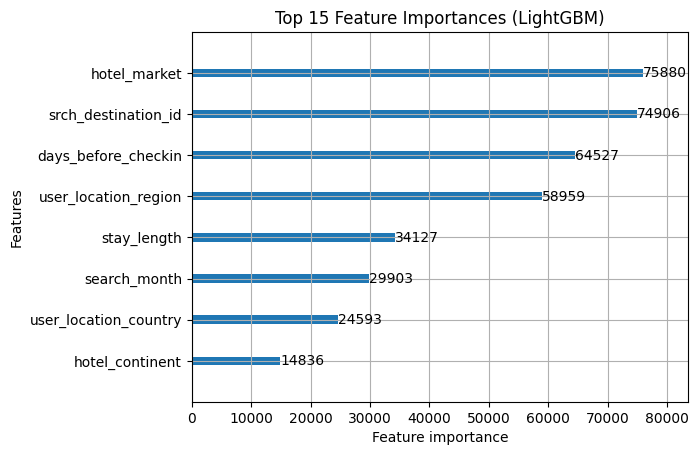

In [13]:
lgb.plot_importance(model_lgb, max_num_features=15)
plt.title("Top 15 Feature Importances (LightGBM)")
plt.show()
